# Basic import

In [1]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt

from pystac.extensions.eo import EOExtension as eo

To use your API key locally, set the environment variable PC_SDK_SUBSCRIPTION_KEY or use pc.settings.set_subscription_key(<YOUR API Key>).

## Data access
The datasets hosted by the Planetary Computer are available from Azure Blob Storage. We'll use pystac-client to search the Planetary Computer's STAC API for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a modifier so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See Reading from the STAC API and Using tokens for data access for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Choose an area and time of interest

This area is in:  

- [-9.7083 ,-39.8532]  Poço de Fora, Curaçá - BA, 48930-000A

Área-piloto 06 - Núcleo do Sertão do São FranciscoA

In [3]:
bbox_of_interest = [-39.0388, -9.8996, 0, 0]#[-39.8532, -9.7083, 0, 0] -9.899662, -39.038805
bbox_of_interest[2] = bbox_of_interest[0] + 0.3138
bbox_of_interest[3] = bbox_of_interest[1] + 0.3138#0.1984
time_of_interest = "2022-01-01/2022-12-31"

In [4]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 1 Items


Let's find the least cloudy of the bunch.

In [5]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC09_L2SP_216067_20221031_02_T1 from 2022-10-31 with 3.62% cloud cover


## Available assets
In addition to numerous metadata assets, each Electro-Optical (EO) band is a separate asset.

In [6]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

## Render a natural color image of the AOI
We'll start by loading the red, green, and blue bands for our area of interest into an xarray dataset using odc-stac. We will also load the nir08 band for use in computing an NDVI value in a later example. Note that we pass the sign function from the planetary-computer package so that odc-stac can supply the required Shared Access Signature tokens that are necessary to download the asset data.

In [7]:
bands_of_interest = ["nir08", "red", "green", "blue", "qa_pixel", "lwir11"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 1157, x: 1149)
Coordinates:
  * y            (y) float64 -1.06e+06 -1.06e+06 ... -1.094e+06 -1.094e+06
  * x            (x) float64 4.958e+05 4.958e+05 ... 5.302e+05 5.302e+05
    spatial_ref  int32 32624
    time         datetime64[ns] 2022-10-31T12:42:39.316409
Data variables:
    nir08        (y, x) uint16 14838 15238 15616 15197 ... 17375 17111 16967
    red          (y, x) uint16 11493 11967 12427 11850 ... 11239 11010 10951
    green        (y, x) uint16 10513 10799 11066 10768 ... 10267 10187 10139
    blue         (y, x) uint16 9278 9329 9478 9197 9344 ... 8769 8782 8665 8731
    qa_pixel     (y, x) uint16 21824 21824 21824 21824 ... 21824 21824 21824
    lwir11       (y, x) uint16 48488 48498 48498 48470 ... 46736 46686 46638

Now we'll convert our xarray Dataset to a DataArray and plot the RGB image. We set robust=True in imshow to avoid manual computation of the color limits (vmin and vmax) that is necessary for data not scaled to between 0-1 while also eliminating extreme values that can cause a washed out image.

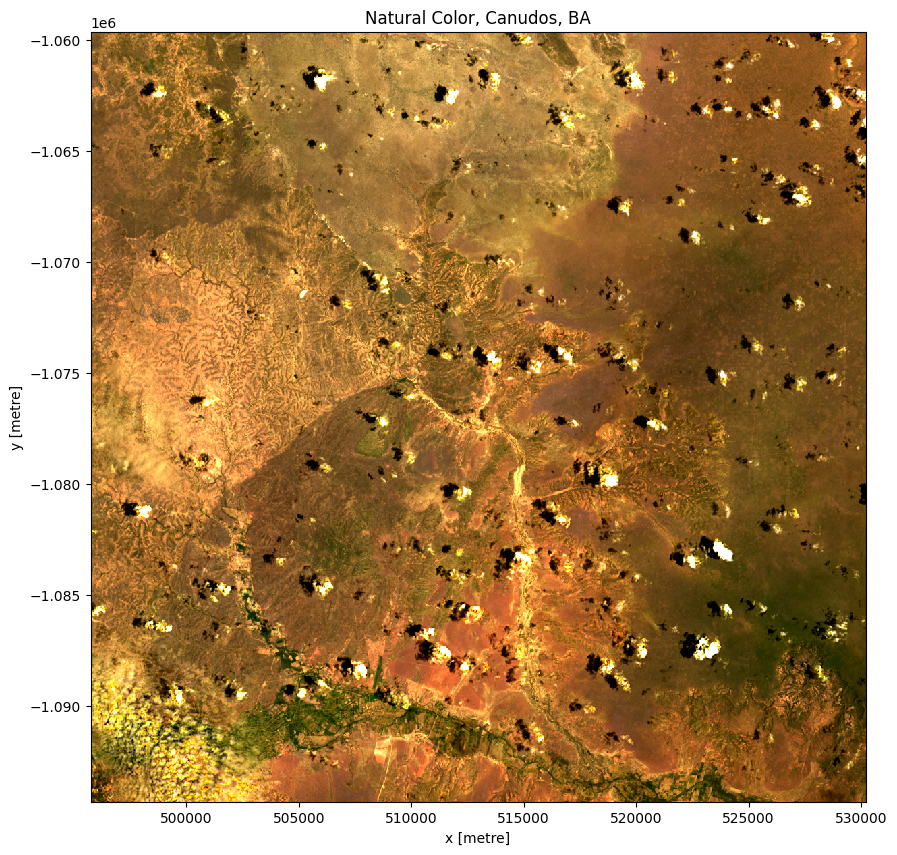

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

data[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax)
ax.set_title("Natural Color, Canudos, BA");

## Render an NDVI image of the AOI
Landsat has several bands, and with them we can go beyond rendering natural color imagery; for example, the following code computes a Normalized Difference Vegetation Index (NDVI) using the near-infrared and red bands. Note that we convert the red and near infrared bands to a data type that can contain negative values; if this is not done, negative NDVI values will be incorrectly stored.

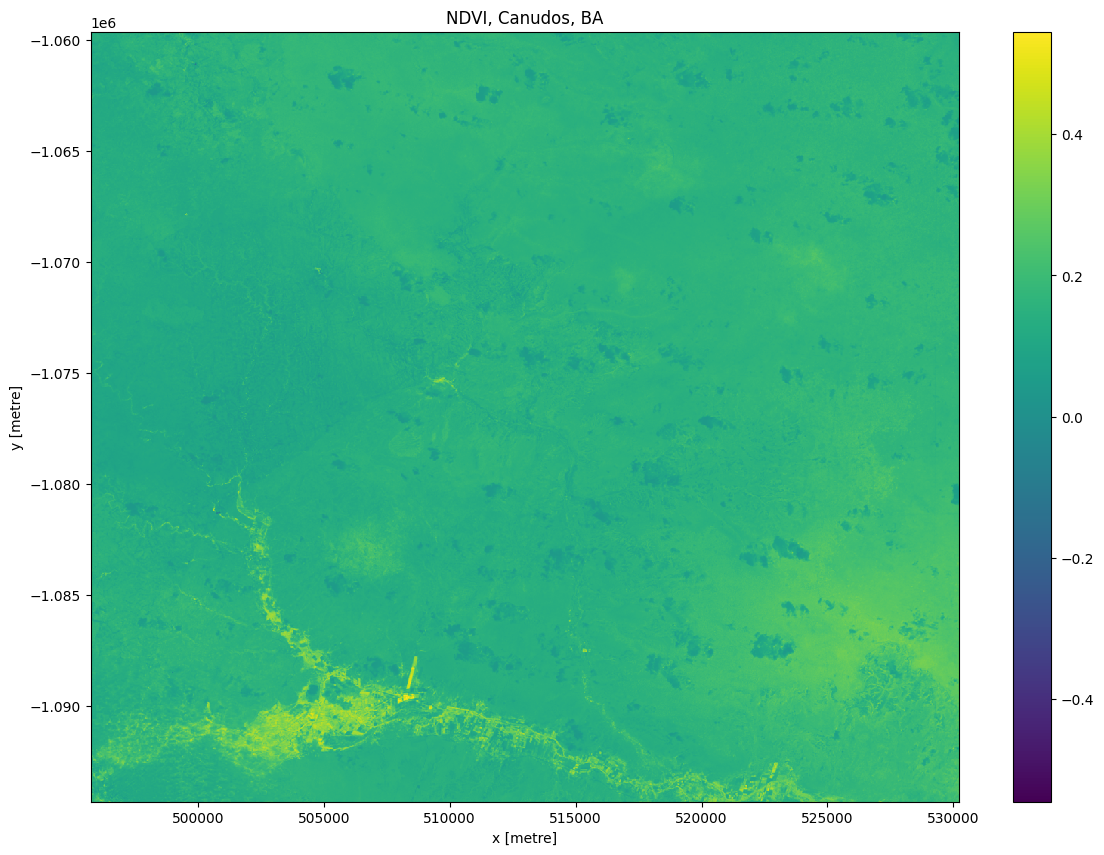

In [9]:
red = data["red"].astype("float")
nir = data["nir08"].astype("float")
ndvi = (nir - red) / (nir + red)

fig, ax = plt.subplots(figsize=(14, 10))
ndvi.plot.imshow(ax=ax, cmap="viridis")
ax.set_title("NDVI, Canudos, BA");

## Selecting specific platforms
Landsat Collection 2 Level-2 includes assets from several different Platforms.

In [10]:
catalog.get_collection("landsat-c2-l2").summaries.to_dict()["platform"]

['landsat-4', 'landsat-5', 'landsat-7', 'landsat-8', 'landsat-9']

You might want to limit your search to a specific platform or platforms, to avoid the Landsat 7 Scan Line Corrector failure, for example. Use the "platform": {"in": ... } query to select specific platforms.

In [11]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {"lt": 10},
        "platform": {"in": ["landsat-8", "landsat-9"]},
    },
)
items = search.item_collection() #Modificado para nova atualização get_all_items() -> item_collection()

## Rescaling Temperature Data
Landsat Collection 2 Level 2 includes measures of Surface Temperature. We'll look at the surface temperature band TIRS_B10 under the key lwir11. The raw values are rescaled, so you should scale and offset the data before interpreting it. Use the metadata in the asset's raster_bands to find the scale and offset values:

In [12]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

o go from the raw values to Kelvin, we apply those values:

In [13]:
temperature = data["lwir11"].astype(float)
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

<xarray.DataArray 'lwir11' (y: 5, x: 5)>
array([[314.73295376, 314.76713396, 314.76713396, 314.6714294 ,
        314.5347086 ],
       [314.8765106 , 314.90727278, 314.90727278, 314.56547078,
        314.3979878 ],
       [314.80473218, 314.80473218, 314.77397   , 314.40824186,
        314.261267  ],
       [314.69535554, 314.65092128, 314.59623296, 314.2270868 ,
        314.11087412],
       [314.61674108, 314.51420048, 314.432168  , 314.08352996,
        314.00833352]])
Coordinates:
  * y            (y) float64 -1.06e+06 -1.06e+06 -1.06e+06 -1.06e+06 -1.06e+06
  * x            (x) float64 4.958e+05 4.958e+05 4.958e+05 4.958e+05 4.959e+05
    spatial_ref  int32 32624
    time         datetime64[ns] 2022-10-31T12:42:39.316409
Attributes:
    nodata:   0

To convert from Kelvin to degrees, subtract 273.15.

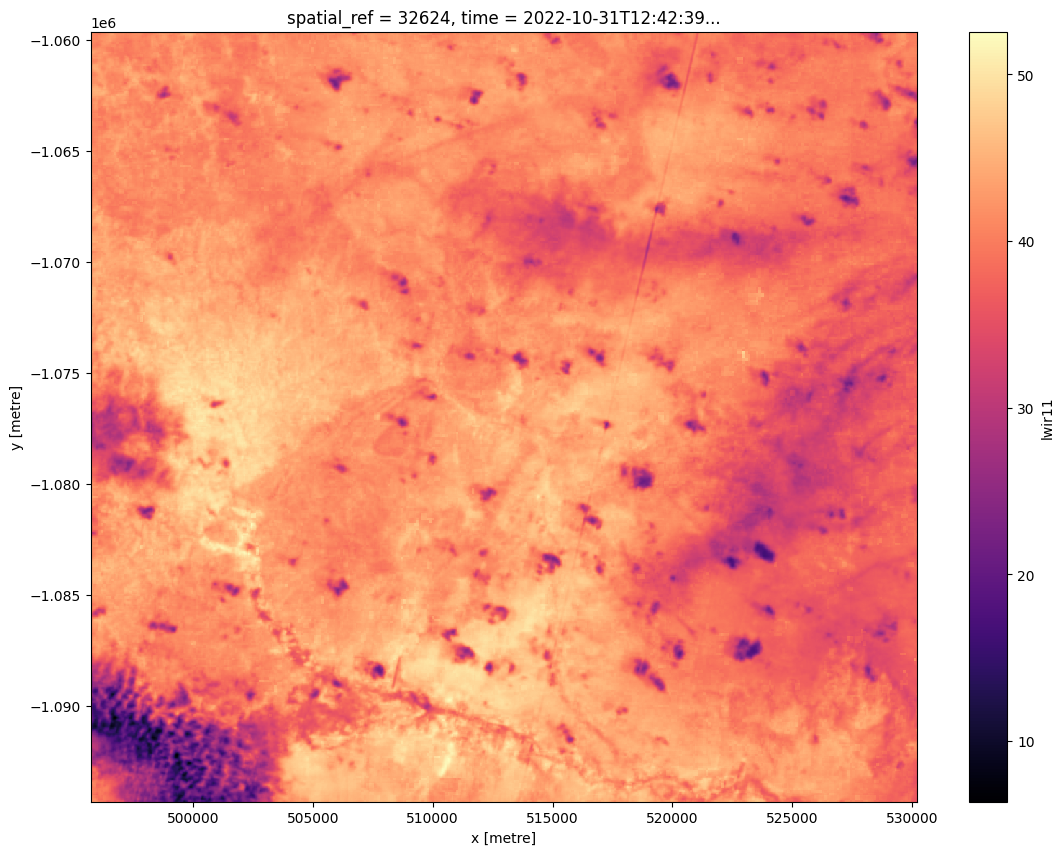

In [14]:
celsius = temperature - 273.15
celsius.plot(cmap="magma", size=10);

## Landsat Collection 2 Level-1 Data
Thus far we have worked with Landsat Collection 2 Level-2 data, which is processed to a consistent set of surface reflectance and surface temperature science products.

The Planetary Computer also hosts Collection 2 Level-1 data (top of atmosphere values) acquired by the Multispectral Scanner System (MSS) onboard Landsat 1 through 5. These data do not include a blue band, so a natural color image is not possible. We will plot a color infrared image from the nir08, red, and green bands instead.

As before, we use pystac-client to search over the landsat-c2-l1 collection. We'll use the same area of interest and return only those with less than 10% cloud cover.

In [15]:
search = catalog.search(
    collections=["landsat-c2-l1"],
    bbox=bbox_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 4 Items


Choose the least cloudy Item.

In [16]:
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LM01_L1TP_232066_19731112_02_T2 from 1973-11-12 with 0.0% cloud cover


## Available assets
MSS data has four EO bands assets and a number of metadata files and bands.

In [17]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

             red: Red Band
           green: Green Band
           nir08: Near Infrared Band 0.8
           nir09: Near Infrared Band 0.9
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Dropped Pixel Quality Assessment Band
        tilejson: TileJSON with default rendering
rendered_preview: Rendered preview


We'll use odc-stac to load only the EO bands and area we are interested in.

/home/gladis/Ambientes/OndasGravitacionais/lib/python3.9/site-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


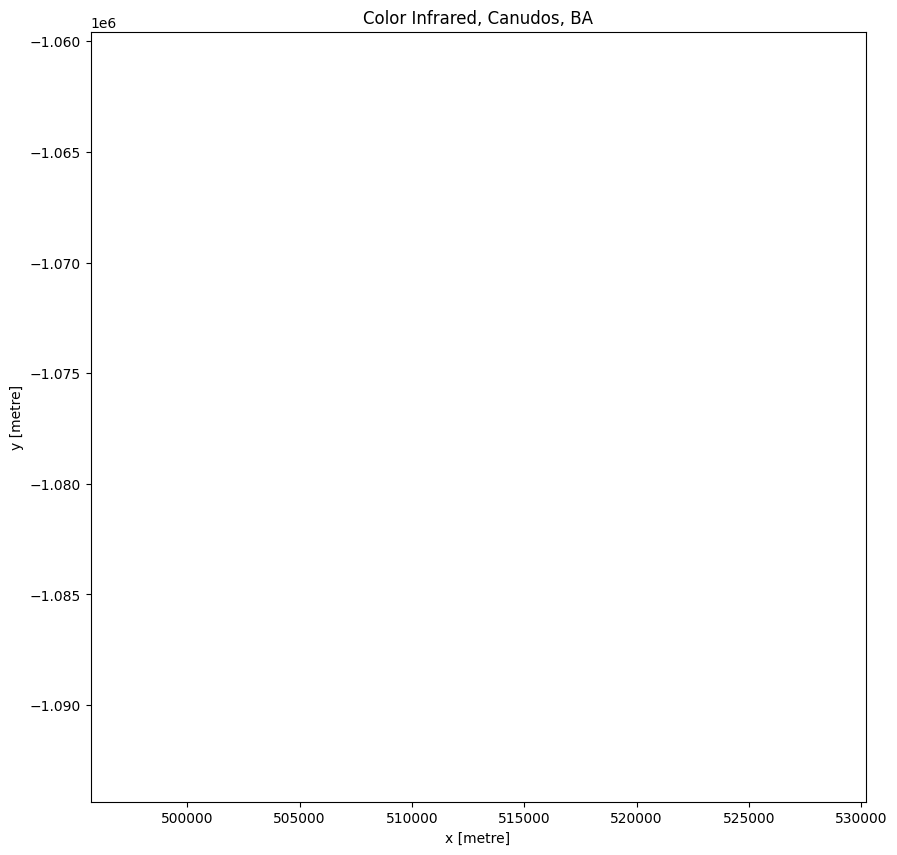

In [18]:
bands_of_interest = ["nir08", "red", "green"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)

cir = data.to_array()

fig, ax = plt.subplots(figsize=(10, 10))
cir.plot.imshow(robust=True, ax=ax)
ax.set_title("Color Infrared, Canudos, BA");